### Core Clustering Logic

In [2]:
# KMeans
import pandas as pd
import mysql.connector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Yoimiya3000!',
    database='employee_db'
)

query = """
SELECT e.employee_id, e.first_name, e.last_name,
       c.city, c.state, comp.salary,
       d.department_name, r.role_name, s.skill_name
FROM employees e
LEFT JOIN contacts c ON e.employee_id = c.employee_id
LEFT JOIN compensation comp ON e.employee_id = comp.employee_id
LEFT JOIN departments d ON e.department_id = d.department_id
LEFT JOIN users u ON e.employee_id = u.employee_id
LEFT JOIN roles r ON u.role_id = r.role_id
LEFT JOIN employee_skills es ON e.employee_id = es.employee_id
LEFT JOIN skills s ON es.skill_id = s.skill_id
"""
df = pd.read_sql(query, conn)
conn.close()

# skill_name -> one-hot encoding
skill_dummies = df.pivot_table(index='employee_id', 
                               columns='skill_name', 
                               aggfunc='size', 
                               fill_value=0)
df = df.drop('skill_name', axis=1).drop_duplicates(subset='employee_id')
df = df.merge(skill_dummies, left_on='employee_id', right_index=True, how='left')
df.fillna(0, inplace=True)

# Feature sets for clustering
feature_sets = {
    "salary_only": ['salary'],
    "location_only": ['city', 'state'],
    "role_only": ['department_name', 'role_name'],
    "skills_only": list(skill_dummies.columns),
    "salary_and_role": ['salary', 'department_name', 'role_name'],
    "location_and_salary": ['salary', 'city', 'state'],
    "all_features": ['salary', 'department_name', 'city', 'state', 'role_name'] + list(skill_dummies.columns)
}

# Looping and Clustering 
for name, feature_cols in feature_sets.items():
    numeric_feats = [f for f in feature_cols if f == 'salary'] # extracts numeric features
    categorical_feats = [f for f in feature_cols if f in ['department_name', 'city', 'state', 'role_name']] # extracts categorical features
    
    # Preprocessing 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_feats),
            ('cat', OneHotEncoder(), categorical_feats)
        ],
        remainder='passthrough'  # any other columns kept as it is
    )
    
    kmeans = KMeans(n_clusters=7, random_state=42)  
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clusterer', kmeans)
    ])
    
    df[f'cluster_{name}'] = pipeline.fit_predict(df[feature_cols]) + 1 # starting from 1
print(df[['employee_id'] + [f'cluster_{name}' for name in feature_sets.keys()]])


C:\Users\akshay teja thota\AppData\Local\Temp\ipykernel_20604\1727410578.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


     employee_id  cluster_salary_only  cluster_location_only  \
0              1                    3                      5   
3              2                    3                      5   
5              3                    3                      1   
8              4                    3                      1   
10             5                    5                      7   
12             6                    5                      7   
14             7                    5                      3   
17             8                    5                      3   
19             9                    5                      6   
21            10                    6                      6   
23            11                    6                      4   
25            12                    6                      4   
27            13                    6                      2   
30            14                    6                      2   
32            15                    6   

### Visualization

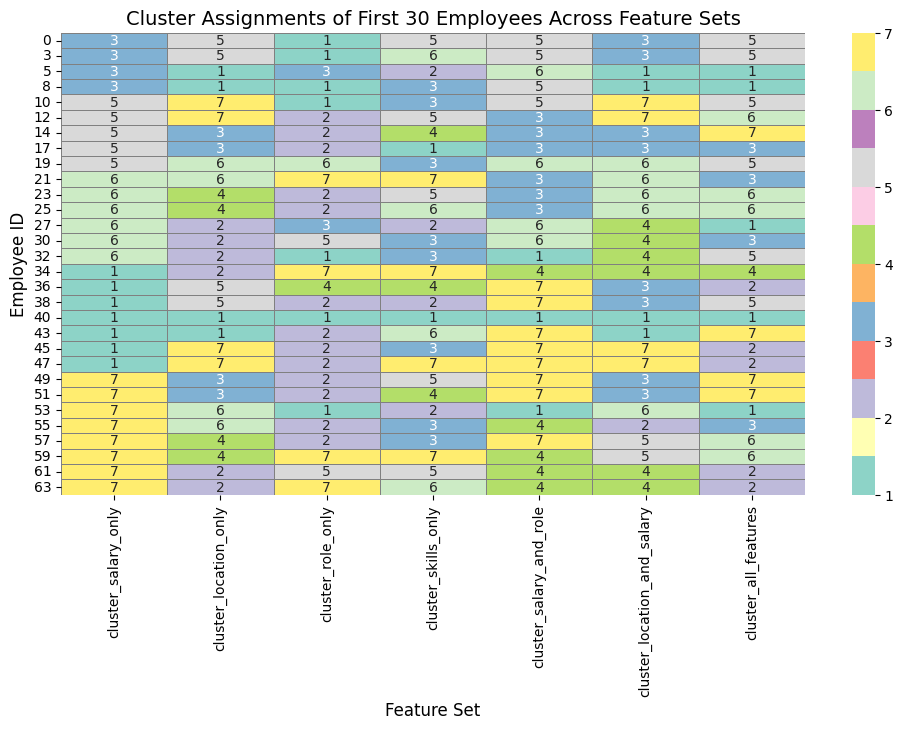

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Limit number of employees for readability (as clumsy)
df_subset = df.head(30)  

plt.figure(figsize=(12,6))
sns.heatmap(
    df_subset[[f'cluster_{name}' for name in feature_sets.keys()]],
    annot=True, fmt='d', cmap='Set3', 
    linewidths=0.5, linecolor='gray',  # grid lines for clarity
    cbar=True
)
plt.title("Cluster Assignments of First 30 Employees Across Feature Sets", fontsize=14)
plt.xlabel("Feature Set", fontsize=12)
plt.ylabel("Employee ID", fontsize=12)
plt.yticks(rotation=0)  
plt.show()

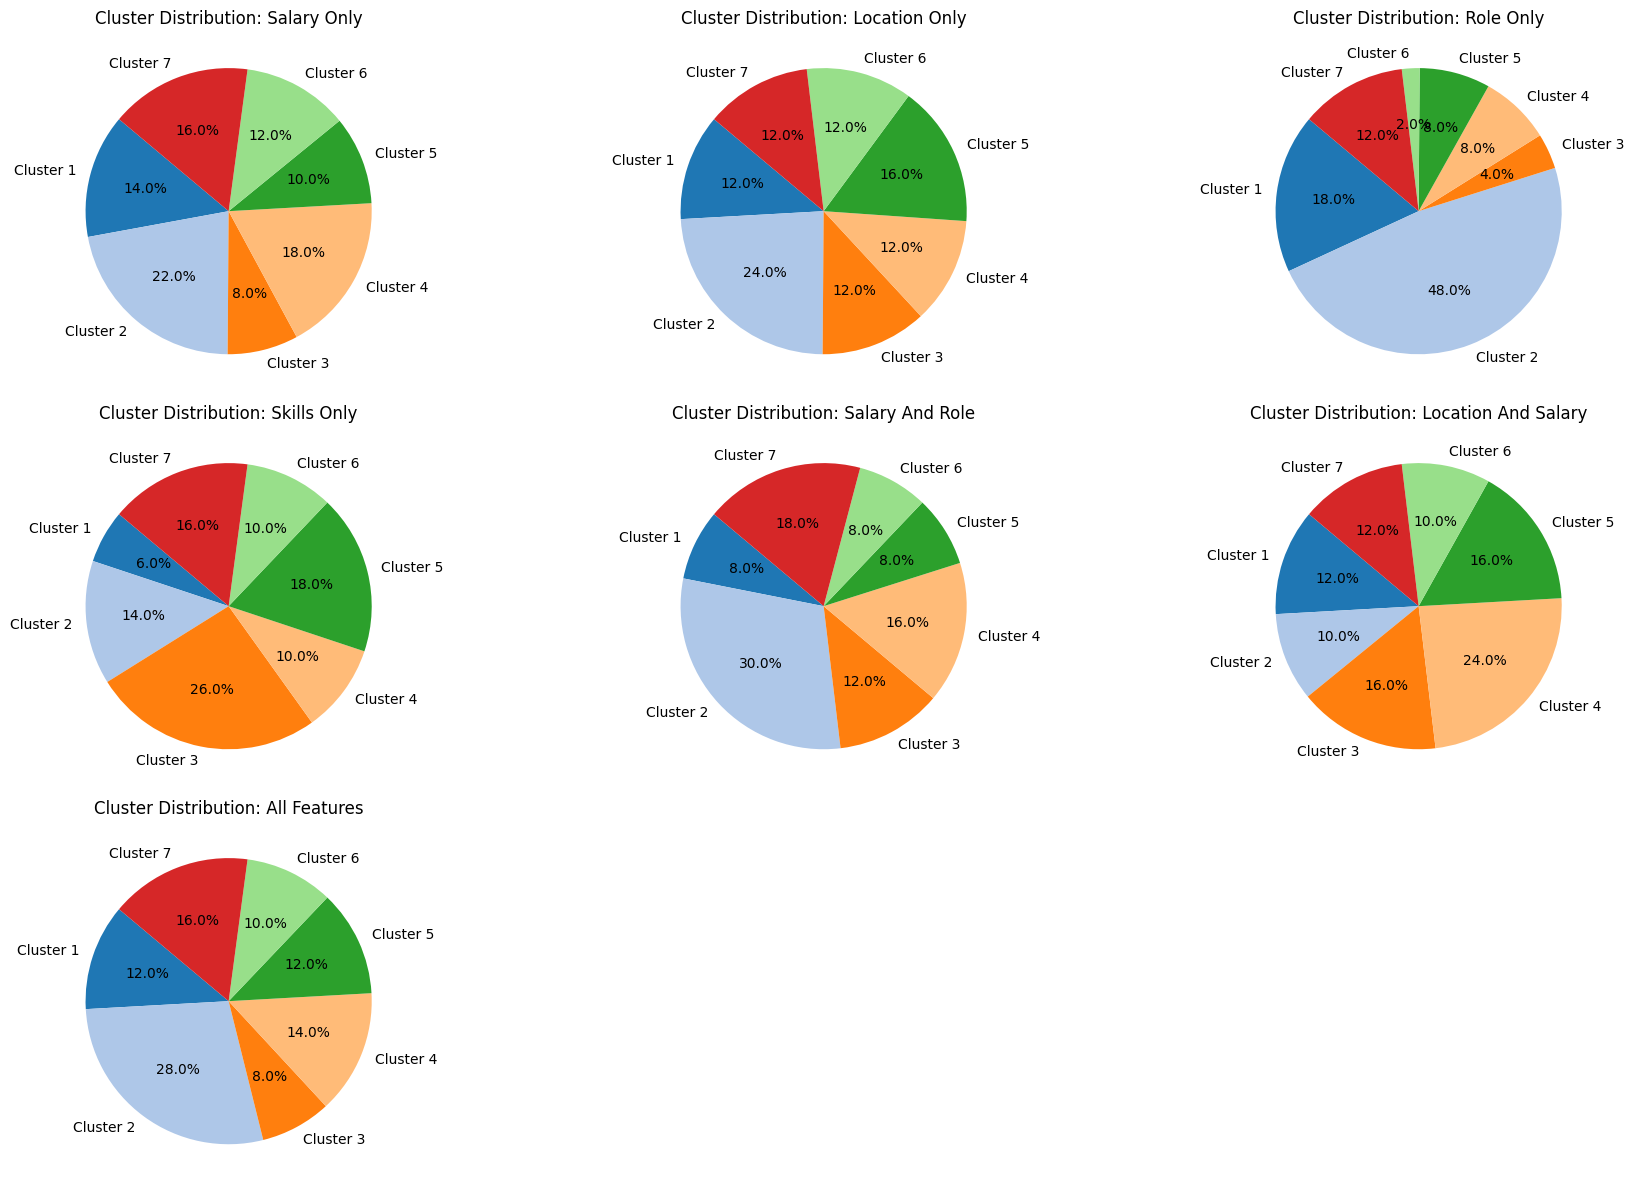

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

# Looping through each feature set
for i, (name, feature_cols) in enumerate(feature_sets.items()):
    plt.subplot(3, 3, i+1)  
    cluster_counts = df[f'cluster_{name}'].value_counts().sort_index()
    plt.pie(cluster_counts, labels=[f"Cluster {c}" for c in cluster_counts.index], 
            autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
    plt.title(f"Cluster Distribution: {name.replace('_', ' ').title()}", fontsize=12)

plt.tight_layout()
plt.show()

In [6]:
# AGNES 
from sklearn.cluster import AgglomerativeClustering

for name, feature_cols in feature_sets.items():
    numeric_feats = [f for f in feature_cols if f == 'salary']
    categorical_feats = [f for f in feature_cols if f in ['department_name', 'city', 'state', 'role_name']]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_feats),
            ('cat', OneHotEncoder(sparse_output=False), categorical_feats)
        ],
        remainder='passthrough'
    )

    agg = AgglomerativeClustering(n_clusters=7)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clusterer', agg)
    ])

    df[f'cluster_agg_{name}'] = pipeline.fit_predict(df[feature_cols]) + 1

print(df[['employee_id'] + [f'cluster_agg_{name}' for name in feature_sets.keys()]])


     employee_id  cluster_agg_salary_only  cluster_agg_location_only  \
0              1                        3                          3   
3              2                        3                          3   
5              3                        3                          7   
8              4                        3                          7   
10             5                        3                          4   
12             6                        3                          4   
14             7                        4                          6   
17             8                        4                          6   
19             9                        4                          5   
21            10                        4                          5   
23            11                        4                          2   
25            12                        4                          2   
27            13                        4                       

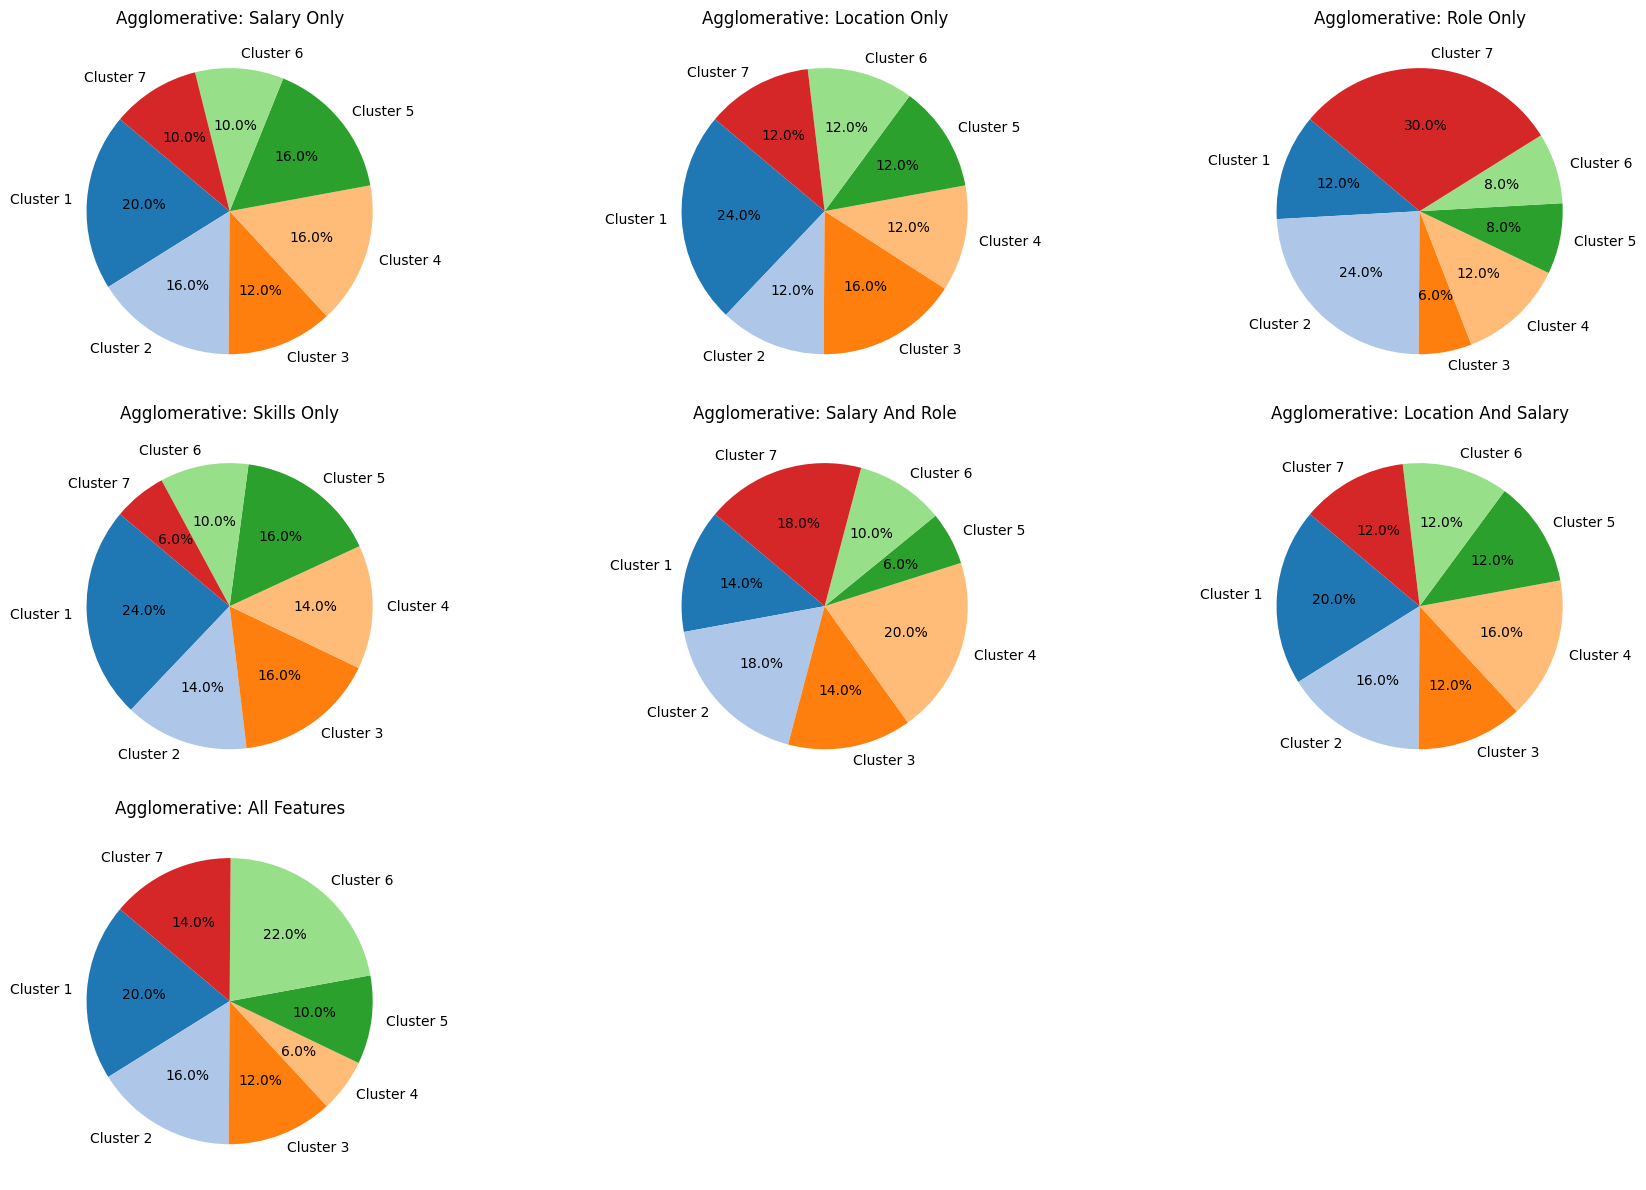

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

for i, name in enumerate(feature_sets.keys()):
    plt.subplot(3, 3, i + 1)

    col = f"cluster_agg_{name}"
    cluster_counts = df[col].value_counts().sort_index()

    plt.pie(
        cluster_counts,
        labels=[f"Cluster {c}" for c in cluster_counts.index],
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.tab20.colors
    )
    plt.title(f"Agglomerative: {name.replace('_', ' ').title()}", fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
# Gaussian
from sklearn.mixture import GaussianMixture

for name, feature_cols in feature_sets.items():
    numeric_feats = [f for f in feature_cols if f == 'salary']
    categorical_feats = [f for f in feature_cols if f in ['department_name', 'city', 'state', 'role_name']]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_feats),
            ('cat', OneHotEncoder(sparse_output=False), categorical_feats)
        ],
        remainder='passthrough'
    )

    gmm = GaussianMixture(n_components=7, random_state=42)

    X_transformed = preprocessor.fit_transform(df[feature_cols])
    df[f'cluster_gmm_{name}'] = gmm.fit_predict(X_transformed) + 1

print(df[['employee_id'] + [f'cluster_gmm_{name}' for name in feature_sets.keys()]])


     employee_id  cluster_gmm_salary_only  cluster_gmm_location_only  \
0              1                        3                          5   
3              2                        3                          5   
5              3                        3                          1   
8              4                        3                          1   
10             5                        5                          7   
12             6                        5                          7   
14             7                        5                          3   
17             8                        5                          3   
19             9                        5                          6   
21            10                        6                          6   
23            11                        6                          4   
25            12                        6                          4   
27            13                        6                       

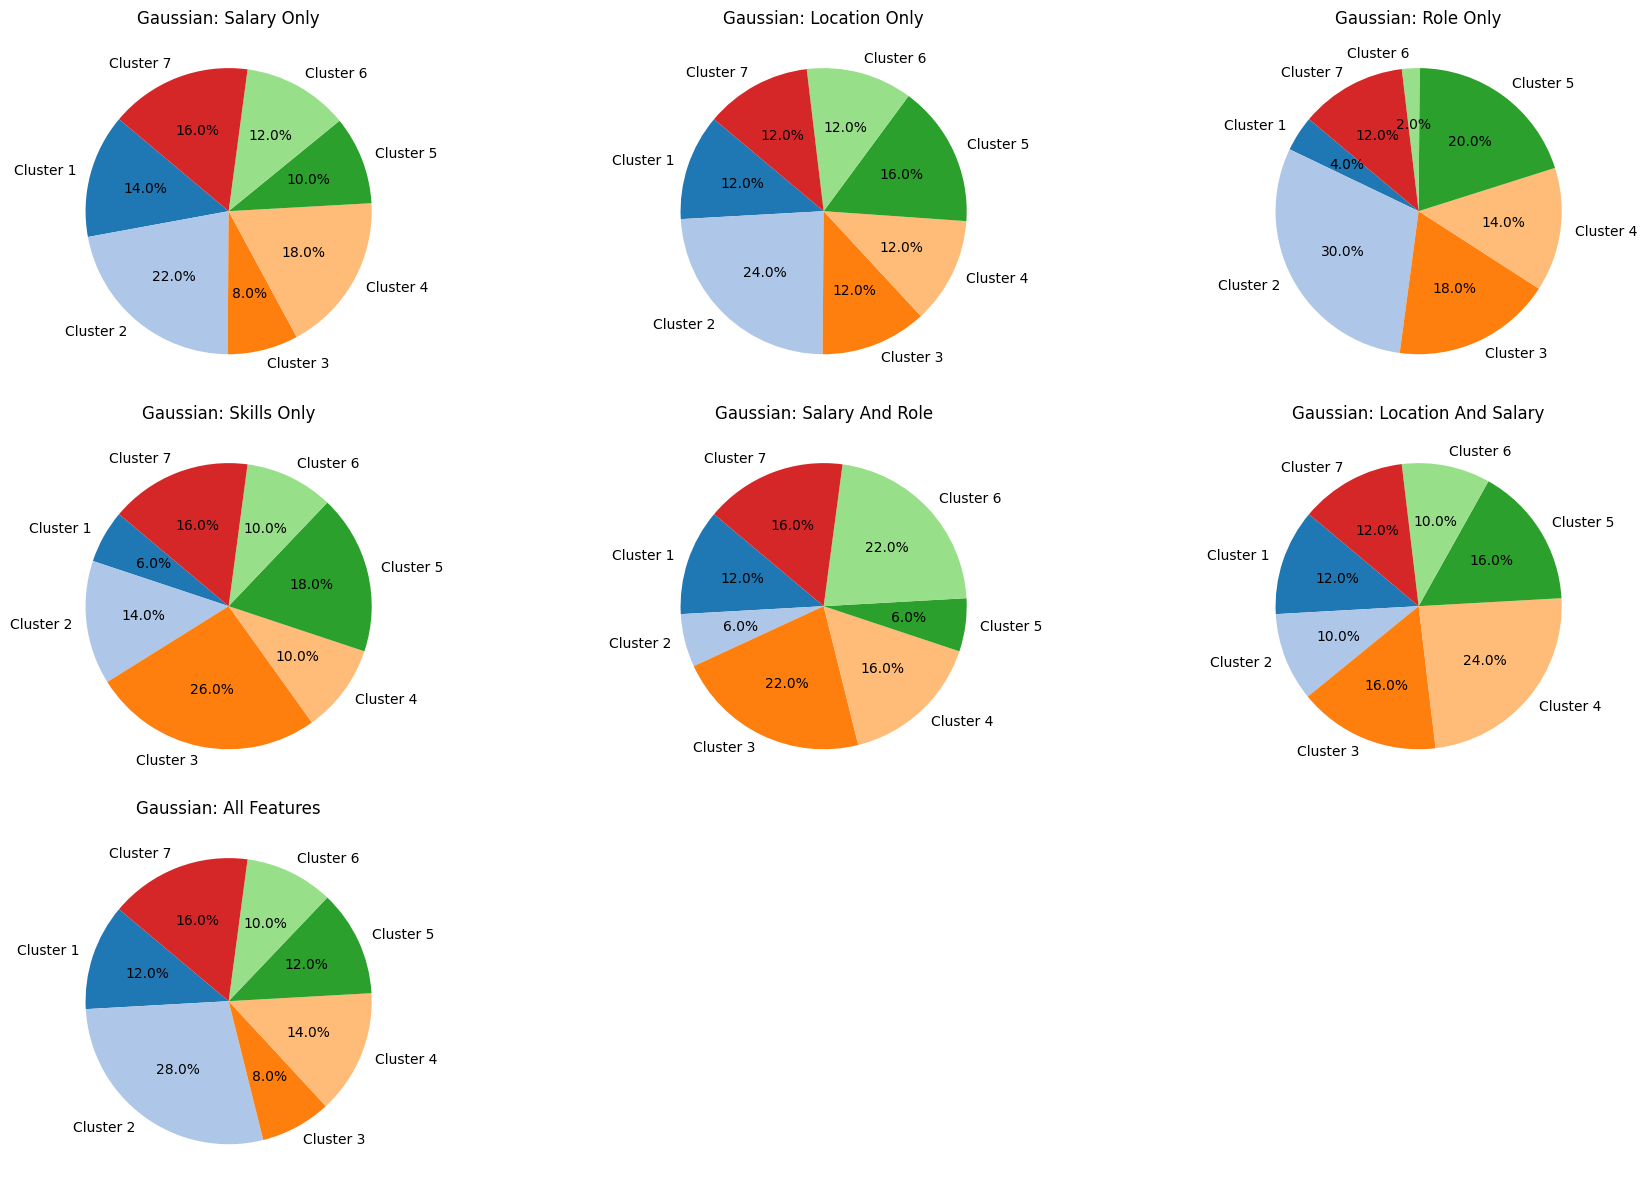

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

for i, name in enumerate(feature_sets.keys()):
    plt.subplot(3, 3, i + 1)

    col = f"cluster_gmm_{name}"
    cluster_counts = df[col].value_counts().sort_index()

    plt.pie(
        cluster_counts,
        labels=[f"Cluster {c}" for c in cluster_counts.index],
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.tab20.colors
    )
    plt.title(f"Gaussian: {name.replace('_', ' ').title()}", fontsize=12)

plt.tight_layout()
plt.show()